## Utility functions and general imports

In [1]:
import h5py
import numpy as np
import scipy as scpy
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from scipy import optimize as opt
#from keras.utils import to_categorical

%matplotlib inline




In [2]:
# Defining utility functions for reading images and data in
def show_image(array, label):
    im = Image.fromarray(array)
    print("Item of label={}".format(label))
    return(imshow(im))

# Defining the sigmoid function required in LR
def sigmoid(z):
    return 1/(1+np.exp(-z))

# Vectorised cost function
def costFunctionReg(theta, X, y, lmbda):
    m = len(y)
    temp1 = np.multiply(y, np.log(sigmoid(np.dot(X, theta))))
    temp2 = np.multiply(1-y, np.log(1-sigmoid(np.dot(X, theta))))
    return np.sum(temp1 + temp2) / (-m) + np.sum(theta[1:]**2) * lmbda / (2*m)

# Vectorised gradient

def gradRegularization(theta, X, y, lmbda):
    m = len(y)
    temp = sigmoid(np.dot(X, theta)) - y
    temp = np.dot(temp.T, X).T / m + theta * lmbda / m
    temp[0] = temp[0] - theta[0] * lmbda / m
    return temp

def cost(theta, X, y):
    predictions = sigmoid(X @ theta)
    predictions[predictions == 1] = 0.999 # log(1)=0 causes error in division
    error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions);
    return sum(error) / len(y);

def cost_gradient(theta, X, y):
    predictions = sigmoid(X @ theta);
    return X.transpose() @ (predictions - y) / len(y)

def construct_conf_mat(actual_y, predicted_prob, pos_class_label, thresh=0.5):
    fp, tp, fn, tn = 0, 0, 0, 0
    for i in range(actual_y.shape[0]):
        if predicted_prob[i] >= thresh:
            if actual_y[i] == pos_class_label:
                tp += 1
            else:
                fp += 1
        else:
            if actual_y[i] == pos_class_label:
                fn += 1
            else:
                tn += 1
    return fp, tp, fn, tn


In [3]:
# Import the files in from python h5 format

with h5py.File('../Input/images_training.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('../Input/labels_training.h5','r') as H:
    label = np.copy(H['label'])
    

with h5py.File('../Input/images_testing.h5','r') as H:
    data_test = np.copy(H['data'])
    
with h5py.File('../Input/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['label'])    

## For reference: https://github.com/zalandoresearch/fashion-mnist



| Label | Description   |
|------|------|
|   0  | T-shirt/top|
|   1  | Trouser|
|   2  | Pullover|
|   3  | Dress|
|   4  | Coat|
|   5  | Sandal|
|   6  | Shirt|
|   7  | Sneaker|
|   8  | Bag|
|   9  | Ankle boot|

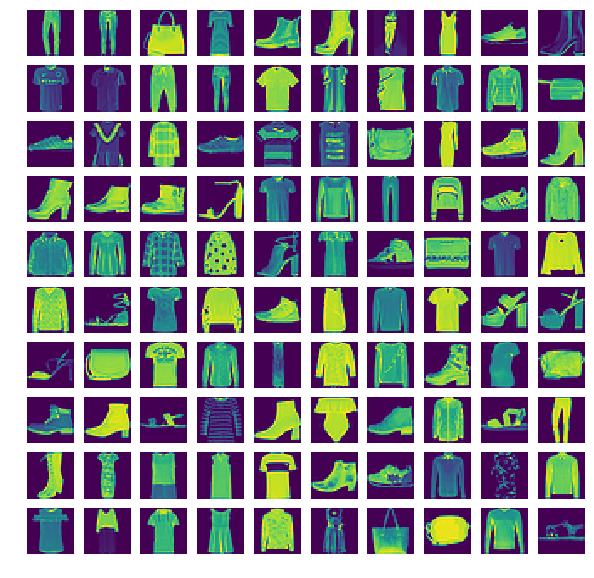

In [4]:
i = 10
#show_image(data[i],label[i])

#print('Total training data shape : ', data.shape, label.shape)
#data_train = data_train / 255


_, axarr = plt.subplots(10,10,figsize=(10,10))

for i in range(10):
    for j in range(10):
       axarr[i,j].imshow(data[np.random.randint(data.shape[0])].\
reshape((28,28), order = 'F'))          
       axarr[i,j].axis('off')     


## Exploratory Analysis

In [5]:
# How many unique classes are we dealing with? Do we need to perform any sampling for class imbalance?
classes = np.unique(label)
nclasses = len(classes)
print('Total number of classes : ', nclasses)
print('Classes to classify are : ', classes)

unique, counts = np.unique(label, return_counts=True)
print('Distribution of labels against total population:')
dict(zip(unique,counts))


Total number of classes :  10
Classes to classify are :  [0 1 2 3 4 5 6 7 8 9]
Distribution of labels against total population:


{0: 3011,
 1: 2956,
 2: 3020,
 3: 3002,
 4: 3029,
 5: 3028,
 6: 2967,
 7: 2895,
 8: 3002,
 9: 3090}

## Shaping the data ready to be processed

In [84]:
data.shape
# Creating a 80/20% split for the training data to be validated on
indices = range(data.shape[0])
training_records = int(0.8 * data.shape[0])


# Get the records that are part of the indices declared above
data_train = data[:training_records]
data_validate = data[training_records:]

# Get the labels that are part of the indices declared above
label_train = label[:training_records]
label_validate = label[training_records:]

data_train = data_train.reshape(-1, 784)
data_validate = data_validate.reshape(-1, 784)
#label_train = label_train.reshape(-1, 1)
label_train = np.squeeze(label_train)
label_validate = np.squeeze(label_validate)

# Standardise all of the input data
#data_train = data_train.astype('float32') /255

records = data_train.shape[0]
records_validate = data_validate.shape[0]
features = data_train.shape[1]
features_validate = data_validate.shape[1]

X = data_train
X_validate = data_validate
y = label_train
y_validate = label_validate

print(X.shape)
print(y.shape)
print(X_validate.shape)
print(y_validate.shape)


print('Total number of records in X train: {}'.format(records))
print('Total number of features in X train: {}'.format(features))

print('Total number of records in X train (valdation set): {}'.format(records_validate))
print('Total number of features in X train (validation set): {}'.format(features_validate))


(24000, 784)
(24000,)
(6000, 784)
(6000,)
Total number of records in X train: 24000
Total number of features in X train: 784
Total number of records in X train (valdation set): 6000
Total number of features in X train (validation set): 784


## How much information is contained for each class - Sample SVD

In [53]:
U, s, Vt = np.linalg.svd(A, full_matrices=True)

S= np.diag(s)
rank = np.linalg.matrix_rank(A)
print(rank)

11


## Setting up terms, intercept and gradients for LogisticRegression - OVR

In [81]:
def add_intercept(X,y):
    m = len(y)
    ones = np.ones((m,1))
    
    X = np.concatenate((ones,X),axis=1)
    m,n = X.shape
    print(X.shape)
    return(X,n)

In [85]:
X,n = add_intercept(X,y)
X_validate, n = add_intercept(X_validate,y_validate)

(24000, 785)
(6000, 785)


## Finding the optimal weights and parameters for the 10 classes

In [ ]:
%%timeit -n 1 -r 1

lmbda = 0.5
k = 10
theta = np.zeros((k,n)) #inital parameters
for i in range(k):
    label_class = i if i else 0
    print('Class {} being optimised'.format(i))
    theta[i] = opt.fmin_cg(f = costFunctionReg, x0 = theta[i],  fprime = gradRegularization, args = (X,(y == label_class).flatten(), lmbda), maxiter = 2000, disp = True)    

Class 0 being optimised


C:\Users\New\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: overflow encountered in exp
C:\Users\New\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: divide by zero encountered in log
C:\Users\New\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in multiply


## Trying a different tack with gradient descent and cost/loss calculations

In [115]:
pred = []
pred = np.argmax(X @ theta.T, axis = 1)
pred = [e if e else 0 for e in pred]
np.mean(pred == y.flatten()) * 100
#79.74166666666666

88.325

In [74]:
predictRandomClass

<function __main__.predictRandomClass>

In [116]:
pred_validate = []
pred_validate = np.argmax(X_validate @ theta.T, axis = 1)
pred = [e if e else 0 for e in pred]
np.mean(pred_validate == y_validate.flatten()) * 100
#79.74166666666666

84.0

In [117]:
print(pred_validate)
print(y_validate)

[1 5 9 ... 3 1 4]
[1 5 9 ... 3 1 2]


In [120]:
print(pred)
print(y)

[0, 2, 6, 5, 2, 2, 2, 7, 5, 5, 5, 8, 4, 4, 8, 3, 9, 1, 9, 8, 6, 0, 9, 4, 8, 2, 6, 8, 6, 0, 1, 7, 7, 9, 3, 3, 8, 4, 7, 2, 8, 3, 8, 0, 8, 3, 5, 0, 5, 6, 4, 7, 3, 7, 4, 9, 6, 0, 3, 7, 2, 0, 0, 8, 3, 0, 9, 0, 3, 0, 5, 7, 5, 5, 7, 2, 6, 3, 1, 7, 5, 8, 4, 4, 2, 3, 9, 4, 0, 2, 5, 0, 4, 6, 9, 4, 8, 4, 2, 2, 1, 3, 7, 9, 6, 6, 0, 8, 5, 1, 8, 2, 3, 1, 0, 9, 5, 4, 7, 0, 2, 7, 9, 9, 8, 7, 3, 4, 4, 4, 9, 6, 3, 8, 2, 4, 1, 6, 2, 0, 8, 4, 9, 2, 1, 8, 4, 7, 5, 4, 9, 7, 1, 5, 3, 5, 2, 3, 4, 7, 2, 3, 0, 2, 3, 2, 0, 3, 9, 6, 5, 3, 4, 8, 3, 8, 5, 8, 1, 9, 9, 0, 5, 2, 4, 0, 9, 3, 4, 0, 2, 4, 1, 9, 7, 4, 0, 8, 2, 7, 0, 8, 0, 5, 8, 3, 8, 8, 0, 7, 7, 7, 6, 8, 3, 5, 1, 2, 4, 1, 4, 0, 2, 7, 2, 3, 0, 0, 5, 3, 3, 0, 2, 8, 1, 9, 4, 4, 0, 3, 7, 8, 0, 4, 5, 4, 6, 0, 0, 3, 7, 2, 6, 8, 9, 0, 8, 2, 4, 5, 8, 3, 9, 5, 4, 2, 3, 1, 3, 7, 5, 0, 9, 3, 8, 4, 3, 9, 7, 6, 9, 2, 5, 0, 4, 0, 4, 8, 1, 6, 5, 1, 2, 9, 4, 3, 8, 9, 8, 7, 3, 7, 5, 5, 7, 4, 7, 5, 1, 4, 5, 3, 5, 2, 1, 3, 7, 5, 8, 5, 9, 2, 8, 3, 9, 3, 4, 0, 5, 6, 0, 3, 4, 